In [1]:
# Parameters
usernames = "r"


In [2]:
# Importing necessary libraries 
import sys
import numpy as np
import emcee
import astropy.io.fits as pyfits

import matplotlib.pylab as pl
import random,os
from multiprocessing import Pool
from multiprocessing import cpu_count
import time
from astropy.io import ascii
import corner
from astropy.table import Column
from astropy.table import join
from IPython.display import clear_output


/Users/suddin/.matplotlib is not a writable directory


Matplotlib created a temporary cache directory at /var/folders/gw/w6qdd1bn6zb2zrvd6dz7_9400000gp/T/matplotlib-9kaj5ib7 because there was an issue with the default path (/Users/suddin/.matplotlib); it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Matplotlib is building the font cache; this may take a moment.


In [3]:
ncpu = cpu_count()
print("{0} CPUs".format(ncpu))
os.environ["OMP_NUM_THREADS"] = "1"

12 CPUs


In [4]:
np.float = float    
np.int = int   #module 'numpy' has no attribute 'int'
np.object = object    #module 'numpy' has no attribute 'object'
np.bool = bool    #module 'numpy' has no attribute 'bool'

In [5]:

# Parameters
filter = f"{usernames}" # Run
#filter='u'
#data
file = filter+'_sbfj21_update3.csv' # change the filaname here if needed for other bands or for other calibrators
tab = ascii.read('../data/'+file)

print(file)

r_sbfj21_update3.csv


In [6]:
c = 300000.
q=-0.53

In [7]:
if not 'SN2011iv' in tab['sn']:
    f = filter+'_trgb_update3.csv' # since SN2011iv is not in filter+'_sbfj21_update3.csv'! 
    t = ascii.read('../data/'+f)
    w = np.where(t['sn']=='SN2011iv')
    t =t[w]
    tab.add_row({'sn':'SN2011iv','dist':31.453,'edist':0.084, 'st':t['st'],'est':t['est'],'Mmax':t['Mmax'], 'eMmax':t['eMmax'],'covMs':t['covMs'],'covBV_M':t['covBV_M'] })
else:
    pass
    
#if filter=='u':
    #if not 'SN2016ajf' in tab['sn']: ## on u-band only since it is missin in u-band SBFJ21 files taken from spreadsheeet: 
    #https://docs.google.com/spreadsheets/d/1DNMwdrrcdxqZYdLHKLKNyWrSCLxvBuFqlXmP18eO3qs/edit?gid=117582066#gid=117582066
 #   tab.add_row({'sn':'SN2016ajf', 'dist':34.202,'edist':0.106, 'st':0.493,'est':0.016,'Mmax':17.787, 'eMmax': 0.086, 'covMs':0.0,'covBV_M':0.0 })
#else:
 #   pass
    

#tab = ascii.read('../data/working/'+file)
st = tab['st']
est = tab['est']
zhel = tab['zhel']
zcmb = tab['zcmb']
mmax = tab['Mmax']
emmax = tab['eMmax']
bv = tab['BV']
ebv = tab['eBV']
m_csp = tab['m']
eml = (tab['m']-tab['ml'])
emu = (tab['mu']-tab['m'])
em = (emu+eml)/2.
dist = tab['dist']
edist = tab['edist']
c_ms = tab['covMs']
c_mbv = tab['covBV_M']
sn = tab['sn']
ebv_host = tab['EBVmw']
# change SNhunt281

#adding more calibrators from Garnavich 2023
#1
c1 = np.where(sn =='SN2006mr') #31.200 ± 0.093
dist[c1]=31.2
edist[c1]=0.093
#print(sn[c1],dist[c1])
#2
c2 = np.where(sn =='SN2007on') # 31.453 ± 0.084
dist[c2]=31.453
edist[c2]=0.084
#print(sn[c2],dist[c2])
#3
c3 = np.where(sn =='SNhunt281')# 32.369,0.078 same as SN2015bp from Jensen 2021
dist[c3]=32.369
edist[c3]=0.078
#print(sn[c3],dist[c3])

# #4
c4 = np.where(sn =='SN2011iv')# # 31.453 ± 0.084
dist[c4]=31.453
edist[c4]=0.084
# print(sn[c4],dist[c4])
# #4
#c5 = np.where(sn =='SN2016ajf')# # 31.453 ± 0.084
#dist[c5]=34.202
#edist[c5]=0.106
#print(sn[c4],dist[c4])



In [8]:
#Selection

#selection = (tab['dist']<0) & (tab['st']<0.75)  & (tab['EBVmw']<0.15) & (tab['zcmb']>0.01)
#w0 = np.where(selection &  (tab['sn']!='CSP14abk') &  (tab['sn']!='PTF13dyt') &  (tab['sn']!='PTF13dym') & (tab['sn']!='PTF14yw') & (tab['sn']!='PS1-13eao') & (tab['subtype']!='Ia-SC') & (tab['subtype']!='Ia-02cx') & (tab['sn']!='LSQ14fmg')& (tab['sn']!='SN2004dt')& (tab['sn']!='SN2005gj')& (tab['sn']!='SN2005hk')& (tab['sn']!='SN2006bt')& (tab['sn']!='SN2006ot')& (tab['sn']!='SN2007so')& (tab['sn']!='SN2008ae')& (tab['sn']!='SN2008bd')& (tab['sn']!='SN2008ha')& (tab['sn']!='SN2008J')& (tab['sn']!='SN2009dc')& (tab['sn']!='SN2009J')& (tab['sn']!='SN2010ae'))
# no cut
#w0 = np.where((tab['sn']!='CSP14abk') &  (tab['sn']!='PTF13dyt') &  (tab['sn']!='PTF13dym') & (tab['sn']!='PTF14yw') & (tab['sn']!='PS1-13eao') & (tab['subtype']!='Ia-SC') & (tab['subtype']!='Ia-02cx') & (tab['sn']!='LSQ14fmg')& (tab['sn']!='SN2004dt')& (tab['sn']!='SN2005gj')& (tab['sn']!='SN2005hk')& (tab['sn']!='SN2006bt')& (tab['sn']!='SN2006ot')& (tab['sn']!='SN2007so')& (tab['sn']!='SN2008ae')& (tab['sn']!='SN2008bd')& (tab['sn']!='SN2008ha')& (tab['sn']!='SN2008J')& (tab['sn']!='SN2009dc')& (tab['sn']!='SN2009J')& (tab['sn']!='SN2010ae') & (tab['dist']<0))
#w1 = np.where((tab['dist']>0) & (tab['st']<0.75) & (tab['EBVmw']<0.15))
#w1 = np.where(tab['dist']>0)


# Mark's list for B-band 
supernovae = Column([
    "SN2004gs", "SN2005bl", "SN2005mc", "SN2006bd", "SN2006eq", "SN2006gj", "SN2006gt", "SN2006hb", "SN2006ob",
    "SN2007al", "SN2007ba", "SN2007hj", "SN2007jh", "SN2007mm", "SN2007N", "SN2007ol", "SN2007ux", "SN2008bd",
    "SN2008bi", "SN2008bt", "SN2008O", "SN2009F", "CSP12J", "CSP15B", "KISS15m", "LSQ11pn", "LSQ12fvl", "LSQ13dkp",
    "LSQ14act", "LSQ14ajn", "LSQ14gfb", "LSQ14ip", "LSQ14jp", "PTF11ppn", "PTF11pra", "PTF14aje", "PTF14w",
    "SN2011jn", "SN2012ij", "SN2013ay", "SN2013bc", "SN2014dn", "CSP13aao"
], name="Supernovae")


w0=[]

supernova_array = np.array(supernovae)
new_array = np.array(sn)
print(len(supernova_array))

# Find indices of matching entries from supernova_column in new_column
match = np.array([np.where(new_array == name)[0][0] if name in new_array else -1 for name in supernova_array])

for name, idx in zip(supernova_array, match):
    if idx != -1:
        #print(f"{name} found at index {idx} in new_column")
        
        w0.append(idx)
    else:
        pass
        #print(f"{name} not found in new_column")
        

### Calibrators B          
calibrators = Column([
    "SN2007cv",
    "SN2008hs",
    "SN2010Y",
    "SN2014bv",
    "SN2016ajf",
    "SN2006mr",
    "SN2007on",
    "SN2008R",
    "SN2011iv",
    "PTF13ebh",
    "CSP15aae",
    "SNhunt281"
],name='Calibrators') 




w1=[]

calibrators_array = np.array(calibrators)
print(len(calibrators_array))

# Find indices of matching entries from supernova_column in new_column
match = np.array([np.where(new_array == name)[0][0] if name in new_array else -1 for name in calibrators_array])

for name, idx in zip(calibrators_array, match):
    if idx != -1:
        #print(f"{name} found at index {idx} in new_column")
        
        w1.append(idx)
    else:
        pass
        #print(f"{name} not found in new_column")
         
        
        
        
        
print (len(sn[w0]),len(sn[w1]))






43
12
43 10


In [9]:
#initial guess
plim=-17, -20
p1lim =-10,20
p2lim = -20,20
rvlim =-5,5
siglim=0,1
h0lim= 50.0,100

In [10]:
# Eqn 9 of Bruns 2018
def distmod(h,z1,z2):
    t1 = (1+z1)/(1+z2)
    t2 = (c*z2)/h
    t3 = 1 + (((1-q)/2)*z2)
    return (5*np.log10(t1*t2*t3)) +25


In [11]:
# Liklihood function
def like(par):
    p,p1,rv,sig,h0 = par

    mu_obs=[]
    mu_model=[]
    mu_stat=[]
    
    if  -25.0<p<14.0  and -100.0<p1<100.0  and -100.<rv<100.0 and 0<sig<100. and  0< h0 < 1000.0: # priors
        

        
        mu_sn = mmax[w0] - p - p1*(st[w0] - 0.5)  - rv*(bv[w0]-0.4) #- alpha*(m_csp[w0]-np.median(m_csp[w0]))

        mu_cal = mmax[w1] - p - p1*(st[w1] - 0.5) - rv*(bv[w1]-0.4) #- alpha*(m_csp[w1]-np.median(m_csp[w1]))
        
        for mu_sn in mu_sn:
            mu_obs.append(mu_sn)
        for mu_cal in mu_cal:
            mu_obs.append(mu_cal)
        mu_model_sn = distmod(h0,zhel[w0],zcmb[w0])
        mu_model_cal = dist[w1]
        for mu_model_sn in mu_model_sn:
            mu_model.append(mu_model_sn)
        for mu_model_cal in mu_model_cal:
            mu_model.append(mu_model_cal)
        
        #fac= (p1+(2*p2*(st[w0]-0.5)))
        #fac1= (p1+(2*p2*(st[w1]-0.5)))
        fac = p1
        fac1 = p1
        
        vel = 300 ## chening how it effect rersult

        err = (fac*est[w0])**2 +emmax[w0]**2 +(rv*ebv[w0])**2+2*fac*c_ms[w0]+rv*c_mbv[w0]+sig**2 + +(0.00000723*vel/zcmb[w0])**2#+(alpha*em[w0])**2
        err1 = ((fac1*est[w1])**2) +(emmax[w1]**2) +((rv*ebv[w1])**2)+(2*fac1*c_ms[w1])+(rv*c_mbv[w1])+sig**2+(edist[w1]**2)#+(alpha*em[w1])**2

        for err in err:
            mu_stat.append(err)
        for err1 in err1:
            mu_stat.append(err1)
        mu_stat=np.sqrt(mu_stat)
 
        mu_obs = np.array(mu_obs)
        mu_model = np.array(mu_model)
        mu_stat = np.array(mu_stat)
        dmu=mu_obs-mu_model
        
        chi =np.sum((dmu)**2/mu_stat**2)
        return -0.5*chi - (0.5*np.sum(np.log(2*np.pi*(mu_stat)**2))) 
    else:
        return -np.inf

In [12]:
# EMCEE
ndim, nwalkers = 5, 60
ssize=1000
burnin = 500


p00 = np.random.rand(nwalkers) * (plim[1] - plim[0]) + plim[0]
p10 = np.random.rand(nwalkers) * (p1lim[1] - p1lim[0]) + p1lim[0]
rv0 = np.random.rand(nwalkers) * (rvlim[1] - rvlim[0]) + rvlim[0]
sig0 = np.random.rand(nwalkers) * (siglim[1] - siglim[0]) + siglim[0]
h00 = np.random.rand(nwalkers) * (h0lim[1] - h0lim[0]) + h0lim[0]

p0 = np.array([p00,p10,rv0,sig0,h00]).T


In [13]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, like)
print ("running mcmc on "+file)
start = time.time()
sampler.run_mcmc(p0,ssize,progress=True)
samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))
end = time.time()
serial_time = end - start
print ("Mean acceptance fraction:", np.mean(sampler.acceptance_fraction))

running mcmc on r_sbfj21_update3.csv


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 2/1000 [00:00<01:13, 13.61it/s]

  0%|          | 4/1000 [00:00<01:11, 13.90it/s]

  1%|          | 6/1000 [00:00<01:32, 10.80it/s]

  1%|          | 8/1000 [00:00<01:24, 11.67it/s]

  1%|          | 10/1000 [00:00<01:18, 12.56it/s]

  1%|          | 12/1000 [00:00<01:17, 12.74it/s]

  1%|▏         | 14/1000 [00:01<01:14, 13.19it/s]

  2%|▏         | 16/1000 [00:01<01:12, 13.51it/s]

  2%|▏         | 18/1000 [00:01<01:11, 13.68it/s]

  2%|▏         | 20/1000 [00:01<01:11, 13.80it/s]

  2%|▏         | 22/1000 [00:01<01:10, 13.88it/s]

  2%|▏         | 24/1000 [00:01<01:10, 13.82it/s]

  3%|▎         | 26/1000 [00:01<01:12, 13.45it/s]

  3%|▎         | 28/1000 [00:02<01:11, 13.58it/s]

  3%|▎         | 30/1000 [00:02<01:10, 13.73it/s]

  3%|▎         | 32/1000 [00:02<01:10, 13.79it/s]

  3%|▎         | 34/1000 [00:02<01:10, 13.66it/s]

  4%|▎         | 36/1000 [00:02<01:12, 13.38it/s]

  4%|▍         | 38/1000 [00:02<01:12, 13.30it/s]

  4%|▍         | 40/1000 [00:03<01:13, 12.98it/s]

  4%|▍         | 42/1000 [00:03<01:12, 13.25it/s]

  4%|▍         | 44/1000 [00:03<01:13, 13.00it/s]

  5%|▍         | 46/1000 [00:03<01:12, 13.20it/s]

  5%|▍         | 48/1000 [00:03<01:12, 13.07it/s]

  5%|▌         | 50/1000 [00:03<01:11, 13.33it/s]

  5%|▌         | 52/1000 [00:03<01:12, 13.14it/s]

  5%|▌         | 54/1000 [00:04<01:10, 13.40it/s]

  6%|▌         | 56/1000 [00:04<01:09, 13.57it/s]

  6%|▌         | 58/1000 [00:04<01:08, 13.74it/s]

  6%|▌         | 60/1000 [00:04<01:07, 13.86it/s]

  6%|▌         | 62/1000 [00:04<01:06, 14.08it/s]

  6%|▋         | 64/1000 [00:04<01:05, 14.23it/s]

  7%|▋         | 66/1000 [00:04<01:05, 14.25it/s]

  7%|▋         | 68/1000 [00:05<01:05, 14.20it/s]

  7%|▋         | 70/1000 [00:05<01:05, 14.15it/s]

  7%|▋         | 72/1000 [00:05<01:05, 14.12it/s]

  7%|▋         | 74/1000 [00:05<01:05, 14.11it/s]

  8%|▊         | 76/1000 [00:05<01:05, 14.09it/s]

  8%|▊         | 78/1000 [00:05<01:05, 14.15it/s]

  8%|▊         | 80/1000 [00:05<01:05, 14.07it/s]

  8%|▊         | 82/1000 [00:06<01:05, 13.95it/s]

  8%|▊         | 84/1000 [00:06<01:05, 13.92it/s]

  9%|▊         | 86/1000 [00:06<01:17, 11.80it/s]

  9%|▉         | 88/1000 [00:06<01:14, 12.26it/s]

  9%|▉         | 90/1000 [00:06<01:11, 12.66it/s]

  9%|▉         | 92/1000 [00:06<01:09, 13.04it/s]

  9%|▉         | 94/1000 [00:07<01:08, 13.26it/s]

 10%|▉         | 96/1000 [00:07<01:07, 13.47it/s]

 10%|▉         | 98/1000 [00:07<01:06, 13.55it/s]

 10%|█         | 100/1000 [00:07<01:05, 13.66it/s]

 10%|█         | 102/1000 [00:07<01:05, 13.74it/s]

 10%|█         | 104/1000 [00:07<01:05, 13.72it/s]

 11%|█         | 106/1000 [00:07<01:04, 13.77it/s]

 11%|█         | 108/1000 [00:08<01:04, 13.77it/s]

 11%|█         | 110/1000 [00:08<01:04, 13.82it/s]

 11%|█         | 112/1000 [00:08<01:04, 13.86it/s]

 11%|█▏        | 114/1000 [00:08<01:03, 13.87it/s]

 12%|█▏        | 116/1000 [00:08<01:03, 13.86it/s]

 12%|█▏        | 118/1000 [00:08<01:03, 13.84it/s]

 12%|█▏        | 120/1000 [00:08<01:03, 13.85it/s]

 12%|█▏        | 122/1000 [00:09<01:03, 13.89it/s]

 12%|█▏        | 124/1000 [00:09<01:03, 13.85it/s]

 13%|█▎        | 126/1000 [00:09<01:02, 13.88it/s]

 13%|█▎        | 128/1000 [00:09<01:02, 13.85it/s]

 13%|█▎        | 130/1000 [00:09<01:02, 13.81it/s]

 13%|█▎        | 132/1000 [00:09<01:02, 13.85it/s]

 13%|█▎        | 134/1000 [00:09<01:02, 13.84it/s]

 14%|█▎        | 136/1000 [00:10<01:02, 13.79it/s]

 14%|█▍        | 138/1000 [00:10<01:07, 12.76it/s]

 14%|█▍        | 140/1000 [00:10<01:06, 12.89it/s]

 14%|█▍        | 142/1000 [00:10<01:04, 13.32it/s]

 14%|█▍        | 144/1000 [00:10<01:03, 13.45it/s]

 15%|█▍        | 146/1000 [00:10<01:02, 13.77it/s]

 15%|█▍        | 148/1000 [00:10<01:01, 13.92it/s]

 15%|█▌        | 150/1000 [00:11<01:00, 14.02it/s]

 15%|█▌        | 152/1000 [00:11<01:00, 14.02it/s]

 15%|█▌        | 154/1000 [00:11<01:00, 13.98it/s]

 16%|█▌        | 156/1000 [00:11<01:00, 14.04it/s]

 16%|█▌        | 158/1000 [00:11<01:00, 14.03it/s]

 16%|█▌        | 160/1000 [00:11<00:59, 14.02it/s]

 16%|█▌        | 162/1000 [00:11<01:00, 13.88it/s]

 16%|█▋        | 164/1000 [00:12<01:00, 13.89it/s]

 17%|█▋        | 166/1000 [00:12<01:17, 10.80it/s]

 17%|█▋        | 168/1000 [00:12<01:14, 11.16it/s]

 17%|█▋        | 170/1000 [00:12<01:15, 10.96it/s]

 17%|█▋        | 172/1000 [00:12<01:13, 11.31it/s]

 17%|█▋        | 174/1000 [00:13<01:10, 11.65it/s]

 18%|█▊        | 176/1000 [00:13<01:09, 11.89it/s]

 18%|█▊        | 178/1000 [00:13<01:06, 12.27it/s]

 18%|█▊        | 180/1000 [00:13<01:04, 12.66it/s]

 18%|█▊        | 182/1000 [00:13<01:03, 12.98it/s]

 18%|█▊        | 184/1000 [00:13<01:03, 12.94it/s]

 19%|█▊        | 186/1000 [00:13<01:01, 13.25it/s]

 19%|█▉        | 188/1000 [00:14<01:00, 13.46it/s]

 19%|█▉        | 190/1000 [00:14<00:59, 13.62it/s]

 19%|█▉        | 192/1000 [00:14<00:58, 13.73it/s]

 19%|█▉        | 194/1000 [00:14<00:58, 13.74it/s]

 20%|█▉        | 196/1000 [00:14<00:58, 13.67it/s]

 20%|█▉        | 198/1000 [00:14<00:58, 13.70it/s]

 20%|██        | 200/1000 [00:14<00:58, 13.73it/s]

 20%|██        | 202/1000 [00:15<00:57, 13.82it/s]

 20%|██        | 204/1000 [00:15<00:57, 13.74it/s]

 21%|██        | 206/1000 [00:15<00:57, 13.76it/s]

 21%|██        | 208/1000 [00:15<00:57, 13.68it/s]

 21%|██        | 210/1000 [00:15<00:57, 13.71it/s]

 21%|██        | 212/1000 [00:15<00:57, 13.67it/s]

 21%|██▏       | 214/1000 [00:15<00:57, 13.76it/s]

 22%|██▏       | 216/1000 [00:16<00:56, 13.81it/s]

 22%|██▏       | 218/1000 [00:16<00:56, 13.82it/s]

 22%|██▏       | 220/1000 [00:16<00:55, 13.93it/s]

 22%|██▏       | 222/1000 [00:16<00:55, 13.96it/s]

 22%|██▏       | 224/1000 [00:16<00:55, 14.09it/s]

 23%|██▎       | 226/1000 [00:16<00:54, 14.15it/s]

 23%|██▎       | 228/1000 [00:16<00:54, 14.27it/s]

 23%|██▎       | 230/1000 [00:17<00:54, 14.23it/s]

 23%|██▎       | 232/1000 [00:17<00:54, 14.19it/s]

 23%|██▎       | 234/1000 [00:17<00:54, 14.11it/s]

 24%|██▎       | 236/1000 [00:17<00:54, 14.10it/s]

 24%|██▍       | 238/1000 [00:17<00:54, 14.08it/s]

 24%|██▍       | 240/1000 [00:17<00:53, 14.08it/s]

 24%|██▍       | 242/1000 [00:17<00:54, 13.99it/s]

 24%|██▍       | 244/1000 [00:18<01:06, 11.34it/s]

 25%|██▍       | 246/1000 [00:18<01:07, 11.12it/s]

 25%|██▍       | 248/1000 [00:18<01:07, 11.19it/s]

 25%|██▌       | 250/1000 [00:18<01:04, 11.70it/s]

 25%|██▌       | 252/1000 [00:18<01:00, 12.28it/s]

 25%|██▌       | 254/1000 [00:19<00:58, 12.66it/s]

 26%|██▌       | 256/1000 [00:19<00:57, 12.92it/s]

 26%|██▌       | 258/1000 [00:19<00:57, 13.00it/s]

 26%|██▌       | 260/1000 [00:19<00:59, 12.52it/s]

 26%|██▌       | 262/1000 [00:19<00:57, 12.81it/s]

 26%|██▋       | 264/1000 [00:19<00:56, 13.05it/s]

 27%|██▋       | 266/1000 [00:19<00:55, 13.30it/s]

 27%|██▋       | 268/1000 [00:20<00:54, 13.37it/s]

 27%|██▋       | 270/1000 [00:20<00:54, 13.51it/s]

 27%|██▋       | 272/1000 [00:20<00:53, 13.50it/s]

 27%|██▋       | 274/1000 [00:20<00:53, 13.56it/s]

 28%|██▊       | 276/1000 [00:20<00:53, 13.58it/s]

 28%|██▊       | 278/1000 [00:20<00:52, 13.62it/s]

 28%|██▊       | 280/1000 [00:20<00:52, 13.65it/s]

 28%|██▊       | 282/1000 [00:21<00:52, 13.59it/s]

 28%|██▊       | 284/1000 [00:21<00:52, 13.64it/s]

 29%|██▊       | 286/1000 [00:21<00:52, 13.68it/s]

 29%|██▉       | 288/1000 [00:21<00:52, 13.66it/s]

 29%|██▉       | 290/1000 [00:21<00:52, 13.63it/s]

 29%|██▉       | 292/1000 [00:21<00:52, 13.60it/s]

 29%|██▉       | 294/1000 [00:21<00:51, 13.72it/s]

 30%|██▉       | 296/1000 [00:22<00:51, 13.70it/s]

 30%|██▉       | 298/1000 [00:22<00:51, 13.71it/s]

 30%|███       | 300/1000 [00:22<00:50, 13.78it/s]

 30%|███       | 302/1000 [00:22<00:50, 13.92it/s]

 30%|███       | 304/1000 [00:22<00:49, 14.06it/s]

 31%|███       | 306/1000 [00:22<00:49, 14.16it/s]

 31%|███       | 308/1000 [00:22<00:48, 14.27it/s]

 31%|███       | 310/1000 [00:23<00:56, 12.14it/s]

 31%|███       | 312/1000 [00:23<00:55, 12.43it/s]

 31%|███▏      | 314/1000 [00:23<00:53, 12.92it/s]

 32%|███▏      | 316/1000 [00:23<00:51, 13.25it/s]

 32%|███▏      | 318/1000 [00:23<00:50, 13.48it/s]

 32%|███▏      | 320/1000 [00:23<00:49, 13.66it/s]

 32%|███▏      | 322/1000 [00:24<00:49, 13.73it/s]

 32%|███▏      | 324/1000 [00:24<00:48, 13.80it/s]

 33%|███▎      | 326/1000 [00:24<00:48, 13.83it/s]

 33%|███▎      | 328/1000 [00:24<00:48, 13.84it/s]

 33%|███▎      | 330/1000 [00:24<00:48, 13.86it/s]

 33%|███▎      | 332/1000 [00:24<00:48, 13.68it/s]

 33%|███▎      | 334/1000 [00:24<00:48, 13.75it/s]

 34%|███▎      | 336/1000 [00:25<00:48, 13.76it/s]

 34%|███▍      | 338/1000 [00:25<00:48, 13.75it/s]

 34%|███▍      | 340/1000 [00:25<00:47, 13.80it/s]

 34%|███▍      | 342/1000 [00:25<00:47, 13.84it/s]

 34%|███▍      | 344/1000 [00:25<00:47, 13.90it/s]

 35%|███▍      | 346/1000 [00:25<00:47, 13.84it/s]

 35%|███▍      | 348/1000 [00:25<00:47, 13.86it/s]

 35%|███▌      | 350/1000 [00:26<00:47, 13.74it/s]

 35%|███▌      | 352/1000 [00:26<00:47, 13.76it/s]

 35%|███▌      | 354/1000 [00:26<00:46, 13.81it/s]

 36%|███▌      | 356/1000 [00:26<00:46, 13.86it/s]

 36%|███▌      | 358/1000 [00:26<00:46, 13.83it/s]

 36%|███▌      | 360/1000 [00:26<00:46, 13.68it/s]

 36%|███▌      | 362/1000 [00:26<00:46, 13.77it/s]

 36%|███▋      | 364/1000 [00:27<00:45, 13.83it/s]

 37%|███▋      | 366/1000 [00:27<00:45, 13.86it/s]

 37%|███▋      | 368/1000 [00:27<00:45, 13.91it/s]

 37%|███▋      | 370/1000 [00:27<00:45, 13.94it/s]

 37%|███▋      | 372/1000 [00:27<00:45, 13.94it/s]

 37%|███▋      | 374/1000 [00:27<00:44, 13.98it/s]

 38%|███▊      | 376/1000 [00:27<00:44, 13.96it/s]

 38%|███▊      | 378/1000 [00:28<00:44, 13.98it/s]

 38%|███▊      | 380/1000 [00:28<00:44, 13.98it/s]

 38%|███▊      | 382/1000 [00:28<00:43, 14.08it/s]

 38%|███▊      | 384/1000 [00:28<00:43, 14.29it/s]

 39%|███▊      | 386/1000 [00:28<00:42, 14.33it/s]

 39%|███▉      | 388/1000 [00:28<00:48, 12.57it/s]

 39%|███▉      | 390/1000 [00:28<00:46, 13.21it/s]

 39%|███▉      | 392/1000 [00:29<00:45, 13.29it/s]

 39%|███▉      | 394/1000 [00:29<00:44, 13.50it/s]

 40%|███▉      | 396/1000 [00:29<00:44, 13.62it/s]

 40%|███▉      | 398/1000 [00:29<00:44, 13.68it/s]

 40%|████      | 400/1000 [00:29<00:43, 13.81it/s]

 40%|████      | 402/1000 [00:29<00:43, 13.87it/s]

 40%|████      | 404/1000 [00:30<00:42, 13.86it/s]

 41%|████      | 406/1000 [00:30<00:42, 13.83it/s]

 41%|████      | 408/1000 [00:30<00:42, 13.82it/s]

 41%|████      | 410/1000 [00:30<00:42, 13.80it/s]

 41%|████      | 412/1000 [00:30<00:42, 13.74it/s]

 41%|████▏     | 414/1000 [00:30<00:42, 13.65it/s]

 42%|████▏     | 416/1000 [00:30<00:42, 13.66it/s]

 42%|████▏     | 418/1000 [00:31<00:43, 13.31it/s]

 42%|████▏     | 420/1000 [00:31<00:43, 13.42it/s]

 42%|████▏     | 422/1000 [00:31<00:43, 13.42it/s]

 42%|████▏     | 424/1000 [00:31<00:42, 13.54it/s]

 43%|████▎     | 426/1000 [00:31<00:42, 13.63it/s]

 43%|████▎     | 428/1000 [00:31<00:41, 13.67it/s]

 43%|████▎     | 430/1000 [00:31<00:41, 13.57it/s]

 43%|████▎     | 432/1000 [00:32<00:41, 13.59it/s]

 43%|████▎     | 434/1000 [00:32<00:41, 13.64it/s]

 44%|████▎     | 436/1000 [00:32<00:41, 13.68it/s]

 44%|████▍     | 438/1000 [00:32<00:41, 13.70it/s]

 44%|████▍     | 440/1000 [00:32<00:41, 13.60it/s]

 44%|████▍     | 442/1000 [00:32<00:41, 13.60it/s]

 44%|████▍     | 444/1000 [00:32<00:42, 13.21it/s]

 45%|████▍     | 446/1000 [00:33<00:42, 13.19it/s]

 45%|████▍     | 448/1000 [00:33<00:41, 13.33it/s]

 45%|████▌     | 450/1000 [00:33<00:41, 13.35it/s]

 45%|████▌     | 452/1000 [00:33<00:40, 13.46it/s]

 45%|████▌     | 454/1000 [00:33<00:46, 11.75it/s]

 46%|████▌     | 456/1000 [00:33<00:46, 11.74it/s]

 46%|████▌     | 458/1000 [00:34<00:44, 12.05it/s]

 46%|████▌     | 460/1000 [00:34<00:43, 12.51it/s]

 46%|████▌     | 462/1000 [00:34<00:41, 12.97it/s]

 46%|████▋     | 464/1000 [00:34<00:41, 12.97it/s]

 47%|████▋     | 466/1000 [00:34<00:44, 11.94it/s]

 47%|████▋     | 468/1000 [00:34<00:42, 12.61it/s]

 47%|████▋     | 470/1000 [00:35<00:40, 13.09it/s]

 47%|████▋     | 472/1000 [00:35<00:39, 13.41it/s]

 47%|████▋     | 474/1000 [00:35<00:38, 13.61it/s]

 48%|████▊     | 476/1000 [00:35<00:38, 13.72it/s]

 48%|████▊     | 478/1000 [00:35<00:37, 13.79it/s]

 48%|████▊     | 480/1000 [00:35<00:37, 13.80it/s]

 48%|████▊     | 482/1000 [00:35<00:37, 13.88it/s]

 48%|████▊     | 484/1000 [00:36<00:39, 13.19it/s]

 49%|████▊     | 486/1000 [00:36<00:38, 13.32it/s]

 49%|████▉     | 488/1000 [00:36<00:37, 13.48it/s]

 49%|████▉     | 490/1000 [00:36<00:37, 13.59it/s]

 49%|████▉     | 492/1000 [00:36<00:39, 13.02it/s]

 49%|████▉     | 494/1000 [00:36<00:40, 12.63it/s]

 50%|████▉     | 496/1000 [00:36<00:38, 12.99it/s]

 50%|████▉     | 498/1000 [00:37<00:37, 13.27it/s]

 50%|█████     | 500/1000 [00:37<00:37, 13.38it/s]

 50%|█████     | 502/1000 [00:37<00:36, 13.53it/s]

 50%|█████     | 504/1000 [00:37<00:36, 13.67it/s]

 51%|█████     | 506/1000 [00:37<00:35, 13.76it/s]

 51%|█████     | 508/1000 [00:37<00:35, 13.81it/s]

 51%|█████     | 510/1000 [00:37<00:35, 13.85it/s]

 51%|█████     | 512/1000 [00:38<00:35, 13.86it/s]

 51%|█████▏    | 514/1000 [00:38<00:34, 13.89it/s]

 52%|█████▏    | 516/1000 [00:38<00:35, 13.83it/s]

 52%|█████▏    | 518/1000 [00:38<00:34, 13.84it/s]

 52%|█████▏    | 520/1000 [00:38<00:34, 13.85it/s]

 52%|█████▏    | 522/1000 [00:38<00:34, 13.87it/s]

 52%|█████▏    | 524/1000 [00:38<00:34, 13.91it/s]

 53%|█████▎    | 526/1000 [00:39<00:34, 13.82it/s]

 53%|█████▎    | 528/1000 [00:39<00:34, 13.84it/s]

 53%|█████▎    | 530/1000 [00:39<00:33, 13.85it/s]

 53%|█████▎    | 532/1000 [00:39<00:33, 13.87it/s]

 53%|█████▎    | 534/1000 [00:39<00:33, 13.89it/s]

 54%|█████▎    | 536/1000 [00:39<00:33, 13.92it/s]

 54%|█████▍    | 538/1000 [00:39<00:33, 13.92it/s]

 54%|█████▍    | 540/1000 [00:40<00:33, 13.85it/s]

 54%|█████▍    | 542/1000 [00:40<00:33, 13.87it/s]

 54%|█████▍    | 544/1000 [00:40<00:32, 14.00it/s]

 55%|█████▍    | 546/1000 [00:40<00:36, 12.42it/s]

 55%|█████▍    | 548/1000 [00:40<00:34, 12.93it/s]

 55%|█████▌    | 550/1000 [00:40<00:33, 13.41it/s]

 55%|█████▌    | 552/1000 [00:41<00:32, 13.80it/s]

 55%|█████▌    | 554/1000 [00:41<00:32, 13.88it/s]

 56%|█████▌    | 556/1000 [00:41<00:31, 13.96it/s]

 56%|█████▌    | 558/1000 [00:41<00:31, 14.00it/s]

 56%|█████▌    | 560/1000 [00:41<00:31, 14.04it/s]

 56%|█████▌    | 562/1000 [00:41<00:31, 14.05it/s]

 56%|█████▋    | 564/1000 [00:41<00:30, 14.07it/s]

 57%|█████▋    | 566/1000 [00:42<00:30, 14.04it/s]

 57%|█████▋    | 568/1000 [00:42<00:30, 14.00it/s]

 57%|█████▋    | 570/1000 [00:42<00:30, 13.93it/s]

 57%|█████▋    | 572/1000 [00:42<00:31, 13.74it/s]

 57%|█████▋    | 574/1000 [00:42<00:31, 13.66it/s]

 58%|█████▊    | 576/1000 [00:42<00:31, 13.61it/s]

 58%|█████▊    | 578/1000 [00:42<00:30, 13.74it/s]

 58%|█████▊    | 580/1000 [00:43<00:30, 13.76it/s]

 58%|█████▊    | 582/1000 [00:43<00:30, 13.83it/s]

 58%|█████▊    | 584/1000 [00:43<00:30, 13.81it/s]

 59%|█████▊    | 586/1000 [00:43<00:29, 13.88it/s]

 59%|█████▉    | 588/1000 [00:43<00:29, 13.87it/s]

 59%|█████▉    | 590/1000 [00:43<00:29, 13.92it/s]

 59%|█████▉    | 592/1000 [00:43<00:29, 13.94it/s]

 59%|█████▉    | 594/1000 [00:44<00:29, 14.00it/s]

 60%|█████▉    | 596/1000 [00:44<00:28, 14.01it/s]

 60%|█████▉    | 598/1000 [00:44<00:28, 13.98it/s]

 60%|██████    | 600/1000 [00:44<00:28, 13.98it/s]

 60%|██████    | 602/1000 [00:44<00:28, 14.00it/s]

 60%|██████    | 604/1000 [00:44<00:28, 13.82it/s]

 61%|██████    | 606/1000 [00:44<00:28, 13.90it/s]

 61%|██████    | 608/1000 [00:45<00:28, 13.95it/s]

 61%|██████    | 610/1000 [00:45<00:27, 14.00it/s]

 61%|██████    | 612/1000 [00:45<00:27, 14.01it/s]

 61%|██████▏   | 614/1000 [00:45<00:27, 14.00it/s]

 62%|██████▏   | 616/1000 [00:45<00:27, 14.03it/s]

 62%|██████▏   | 618/1000 [00:45<00:27, 14.03it/s]

 62%|██████▏   | 620/1000 [00:45<00:27, 14.04it/s]

 62%|██████▏   | 622/1000 [00:46<00:26, 14.04it/s]

 62%|██████▏   | 624/1000 [00:46<00:26, 14.05it/s]

 63%|██████▎   | 626/1000 [00:46<00:26, 14.01it/s]

 63%|██████▎   | 628/1000 [00:46<00:30, 12.38it/s]

 63%|██████▎   | 630/1000 [00:46<00:28, 13.00it/s]

 63%|██████▎   | 632/1000 [00:46<00:27, 13.40it/s]

 63%|██████▎   | 634/1000 [00:46<00:26, 13.76it/s]

 64%|██████▎   | 636/1000 [00:47<00:26, 13.87it/s]

 64%|██████▍   | 638/1000 [00:47<00:26, 13.86it/s]

 64%|██████▍   | 640/1000 [00:47<00:25, 13.89it/s]

 64%|██████▍   | 642/1000 [00:47<00:25, 13.92it/s]

 64%|██████▍   | 644/1000 [00:47<00:25, 13.90it/s]

 65%|██████▍   | 646/1000 [00:47<00:25, 13.96it/s]

 65%|██████▍   | 648/1000 [00:47<00:25, 13.90it/s]

 65%|██████▌   | 650/1000 [00:48<00:25, 13.90it/s]

 65%|██████▌   | 652/1000 [00:48<00:25, 13.62it/s]

 65%|██████▌   | 654/1000 [00:48<00:26, 13.13it/s]

 66%|██████▌   | 656/1000 [00:48<00:25, 13.29it/s]

 66%|██████▌   | 658/1000 [00:48<00:25, 13.46it/s]

 66%|██████▌   | 660/1000 [00:48<00:24, 13.62it/s]

 66%|██████▌   | 662/1000 [00:48<00:24, 13.73it/s]

 66%|██████▋   | 664/1000 [00:49<00:24, 13.80it/s]

 67%|██████▋   | 666/1000 [00:49<00:24, 13.83it/s]

 67%|██████▋   | 668/1000 [00:49<00:24, 13.80it/s]

 67%|██████▋   | 670/1000 [00:49<00:24, 13.22it/s]

 67%|██████▋   | 672/1000 [00:49<00:24, 13.42it/s]

 67%|██████▋   | 674/1000 [00:49<00:23, 13.61it/s]

 68%|██████▊   | 676/1000 [00:50<00:24, 13.28it/s]

 68%|██████▊   | 678/1000 [00:50<00:23, 13.49it/s]

 68%|██████▊   | 680/1000 [00:50<00:23, 13.65it/s]

 68%|██████▊   | 682/1000 [00:50<00:23, 13.71it/s]

 68%|██████▊   | 684/1000 [00:50<00:23, 13.71it/s]

 69%|██████▊   | 686/1000 [00:50<00:22, 13.74it/s]

 69%|██████▉   | 688/1000 [00:50<00:22, 13.82it/s]

 69%|██████▉   | 690/1000 [00:51<00:22, 13.87it/s]

 69%|██████▉   | 692/1000 [00:51<00:22, 13.92it/s]

 69%|██████▉   | 694/1000 [00:51<00:21, 13.93it/s]

 70%|██████▉   | 696/1000 [00:51<00:21, 13.96it/s]

 70%|██████▉   | 698/1000 [00:51<00:21, 13.95it/s]

 70%|███████   | 700/1000 [00:51<00:21, 13.91it/s]

 70%|███████   | 702/1000 [00:51<00:21, 13.93it/s]

 70%|███████   | 704/1000 [00:52<00:22, 13.29it/s]

 71%|███████   | 706/1000 [00:52<00:22, 13.24it/s]

 71%|███████   | 708/1000 [00:52<00:24, 12.02it/s]

 71%|███████   | 710/1000 [00:52<00:23, 12.47it/s]

 71%|███████   | 712/1000 [00:52<00:22, 12.94it/s]

 71%|███████▏  | 714/1000 [00:52<00:21, 13.29it/s]

 72%|███████▏  | 716/1000 [00:52<00:21, 13.45it/s]

 72%|███████▏  | 718/1000 [00:53<00:20, 13.65it/s]

 72%|███████▏  | 720/1000 [00:53<00:20, 13.78it/s]

 72%|███████▏  | 722/1000 [00:53<00:20, 13.89it/s]

 72%|███████▏  | 724/1000 [00:53<00:19, 13.86it/s]

 73%|███████▎  | 726/1000 [00:53<00:19, 13.71it/s]

 73%|███████▎  | 728/1000 [00:53<00:19, 13.79it/s]

 73%|███████▎  | 730/1000 [00:54<00:20, 13.24it/s]

 73%|███████▎  | 732/1000 [00:54<00:20, 13.39it/s]

 73%|███████▎  | 734/1000 [00:54<00:19, 13.54it/s]

 74%|███████▎  | 736/1000 [00:54<00:19, 13.65it/s]

 74%|███████▍  | 738/1000 [00:54<00:19, 13.72it/s]

 74%|███████▍  | 740/1000 [00:54<00:18, 13.79it/s]

 74%|███████▍  | 742/1000 [00:54<00:18, 13.86it/s]

 74%|███████▍  | 744/1000 [00:55<00:18, 13.53it/s]

 75%|███████▍  | 746/1000 [00:55<00:18, 13.69it/s]

 75%|███████▍  | 748/1000 [00:55<00:18, 13.77it/s]

 75%|███████▌  | 750/1000 [00:55<00:18, 13.85it/s]

 75%|███████▌  | 752/1000 [00:55<00:17, 13.90it/s]

 75%|███████▌  | 754/1000 [00:55<00:17, 13.88it/s]

 76%|███████▌  | 756/1000 [00:55<00:17, 13.89it/s]

 76%|███████▌  | 758/1000 [00:56<00:17, 13.92it/s]

 76%|███████▌  | 760/1000 [00:56<00:17, 13.95it/s]

 76%|███████▌  | 762/1000 [00:56<00:16, 14.01it/s]

 76%|███████▋  | 764/1000 [00:56<00:16, 13.99it/s]

 77%|███████▋  | 766/1000 [00:56<00:16, 13.96it/s]

 77%|███████▋  | 768/1000 [00:56<00:16, 13.93it/s]

 77%|███████▋  | 770/1000 [00:56<00:16, 13.90it/s]

 77%|███████▋  | 772/1000 [00:57<00:16, 13.88it/s]

 77%|███████▋  | 774/1000 [00:57<00:16, 13.93it/s]

 78%|███████▊  | 776/1000 [00:57<00:16, 13.93it/s]

 78%|███████▊  | 778/1000 [00:57<00:15, 13.96it/s]

 78%|███████▊  | 780/1000 [00:57<00:15, 13.99it/s]

 78%|███████▊  | 782/1000 [00:57<00:15, 14.01it/s]

 78%|███████▊  | 784/1000 [00:57<00:15, 14.00it/s]

 79%|███████▊  | 786/1000 [00:58<00:15, 13.99it/s]

 79%|███████▉  | 788/1000 [00:58<00:15, 14.00it/s]

 79%|███████▉  | 790/1000 [00:58<00:17, 12.07it/s]

 79%|███████▉  | 792/1000 [00:58<00:16, 12.81it/s]

 79%|███████▉  | 794/1000 [00:58<00:15, 13.19it/s]

 80%|███████▉  | 796/1000 [00:58<00:15, 13.53it/s]

 80%|███████▉  | 798/1000 [00:58<00:14, 13.89it/s]

 80%|████████  | 800/1000 [00:59<00:14, 14.00it/s]

 80%|████████  | 802/1000 [00:59<00:14, 13.96it/s]

 80%|████████  | 804/1000 [00:59<00:14, 13.95it/s]

 81%|████████  | 806/1000 [00:59<00:13, 13.96it/s]

 81%|████████  | 808/1000 [00:59<00:13, 13.98it/s]

 81%|████████  | 810/1000 [00:59<00:13, 13.98it/s]

 81%|████████  | 812/1000 [00:59<00:13, 13.88it/s]

 81%|████████▏ | 814/1000 [01:00<00:13, 13.88it/s]

 82%|████████▏ | 816/1000 [01:00<00:13, 13.85it/s]

 82%|████████▏ | 818/1000 [01:00<00:13, 13.81it/s]

 82%|████████▏ | 820/1000 [01:00<00:13, 13.79it/s]

 82%|████████▏ | 822/1000 [01:00<00:12, 13.78it/s]

 82%|████████▏ | 824/1000 [01:00<00:12, 13.77it/s]

 83%|████████▎ | 826/1000 [01:00<00:12, 13.53it/s]

 83%|████████▎ | 828/1000 [01:01<00:12, 13.28it/s]

 83%|████████▎ | 830/1000 [01:01<00:12, 13.42it/s]

 83%|████████▎ | 832/1000 [01:01<00:12, 13.56it/s]

 83%|████████▎ | 834/1000 [01:01<00:12, 13.58it/s]

 84%|████████▎ | 836/1000 [01:01<00:12, 13.62it/s]

 84%|████████▍ | 838/1000 [01:01<00:11, 13.62it/s]

 84%|████████▍ | 840/1000 [01:02<00:11, 13.60it/s]

 84%|████████▍ | 842/1000 [01:02<00:11, 13.66it/s]

 84%|████████▍ | 844/1000 [01:02<00:11, 13.72it/s]

 85%|████████▍ | 846/1000 [01:02<00:11, 13.77it/s]

 85%|████████▍ | 848/1000 [01:02<00:11, 13.63it/s]

 85%|████████▌ | 850/1000 [01:02<00:11, 13.62it/s]

 85%|████████▌ | 852/1000 [01:02<00:10, 13.66it/s]

 85%|████████▌ | 854/1000 [01:03<00:11, 13.19it/s]

 86%|████████▌ | 856/1000 [01:03<00:10, 13.27it/s]

 86%|████████▌ | 858/1000 [01:03<00:10, 13.43it/s]

 86%|████████▌ | 860/1000 [01:03<00:10, 13.45it/s]

 86%|████████▌ | 862/1000 [01:03<00:10, 13.55it/s]

 86%|████████▋ | 864/1000 [01:03<00:10, 13.59it/s]

 87%|████████▋ | 866/1000 [01:03<00:09, 13.63it/s]

 87%|████████▋ | 868/1000 [01:04<00:11, 11.43it/s]

 87%|████████▋ | 870/1000 [01:04<00:11, 11.70it/s]

 87%|████████▋ | 872/1000 [01:04<00:10, 12.42it/s]

 87%|████████▋ | 874/1000 [01:04<00:09, 12.99it/s]

 88%|████████▊ | 876/1000 [01:04<00:09, 13.32it/s]

 88%|████████▊ | 878/1000 [01:04<00:09, 13.52it/s]

 88%|████████▊ | 880/1000 [01:05<00:08, 13.72it/s]

 88%|████████▊ | 882/1000 [01:05<00:08, 13.71it/s]

 88%|████████▊ | 884/1000 [01:05<00:08, 13.80it/s]

 89%|████████▊ | 886/1000 [01:05<00:08, 13.84it/s]

 89%|████████▉ | 888/1000 [01:05<00:08, 13.94it/s]

 89%|████████▉ | 890/1000 [01:05<00:07, 14.04it/s]

 89%|████████▉ | 892/1000 [01:05<00:07, 14.07it/s]

 89%|████████▉ | 894/1000 [01:06<00:07, 13.55it/s]

 90%|████████▉ | 896/1000 [01:06<00:07, 13.41it/s]

 90%|████████▉ | 898/1000 [01:06<00:07, 13.59it/s]

 90%|█████████ | 900/1000 [01:06<00:07, 13.72it/s]

 90%|█████████ | 902/1000 [01:06<00:07, 13.77it/s]

 90%|█████████ | 904/1000 [01:06<00:06, 13.72it/s]

 91%|█████████ | 906/1000 [01:06<00:06, 13.75it/s]

 91%|█████████ | 908/1000 [01:07<00:06, 13.76it/s]

 91%|█████████ | 910/1000 [01:07<00:06, 13.84it/s]

 91%|█████████ | 912/1000 [01:07<00:06, 13.88it/s]

 91%|█████████▏| 914/1000 [01:07<00:06, 13.89it/s]

 92%|█████████▏| 916/1000 [01:07<00:06, 13.54it/s]

 92%|█████████▏| 918/1000 [01:07<00:06, 13.56it/s]

 92%|█████████▏| 920/1000 [01:07<00:05, 13.71it/s]

 92%|█████████▏| 922/1000 [01:08<00:05, 13.77it/s]

 92%|█████████▏| 924/1000 [01:08<00:05, 13.88it/s]

 93%|█████████▎| 926/1000 [01:08<00:05, 13.68it/s]

 93%|█████████▎| 928/1000 [01:08<00:05, 13.77it/s]

 93%|█████████▎| 930/1000 [01:08<00:05, 13.85it/s]

 93%|█████████▎| 932/1000 [01:08<00:04, 13.76it/s]

 93%|█████████▎| 934/1000 [01:08<00:04, 13.86it/s]

 94%|█████████▎| 936/1000 [01:09<00:04, 13.89it/s]

 94%|█████████▍| 938/1000 [01:09<00:04, 13.88it/s]

 94%|█████████▍| 940/1000 [01:09<00:04, 13.86it/s]

 94%|█████████▍| 942/1000 [01:09<00:04, 13.90it/s]

 94%|█████████▍| 944/1000 [01:09<00:04, 13.92it/s]

 95%|█████████▍| 946/1000 [01:09<00:03, 13.93it/s]

 95%|█████████▍| 948/1000 [01:10<00:04, 12.01it/s]

 95%|█████████▌| 950/1000 [01:10<00:04, 12.39it/s]

 95%|█████████▌| 952/1000 [01:10<00:03, 12.84it/s]

 95%|█████████▌| 954/1000 [01:10<00:03, 13.35it/s]

 96%|█████████▌| 956/1000 [01:10<00:03, 13.54it/s]

 96%|█████████▌| 958/1000 [01:10<00:03, 13.87it/s]

 96%|█████████▌| 960/1000 [01:10<00:02, 14.02it/s]

 96%|█████████▌| 962/1000 [01:11<00:02, 14.25it/s]

 96%|█████████▋| 964/1000 [01:11<00:02, 14.22it/s]

 97%|█████████▋| 966/1000 [01:11<00:02, 14.20it/s]

 97%|█████████▋| 968/1000 [01:11<00:02, 14.19it/s]

 97%|█████████▋| 970/1000 [01:11<00:02, 14.18it/s]

 97%|█████████▋| 972/1000 [01:11<00:01, 14.16it/s]

 97%|█████████▋| 974/1000 [01:11<00:01, 14.17it/s]

 98%|█████████▊| 976/1000 [01:12<00:01, 14.11it/s]

 98%|█████████▊| 978/1000 [01:12<00:01, 14.00it/s]

 98%|█████████▊| 980/1000 [01:12<00:01, 13.92it/s]

 98%|█████████▊| 982/1000 [01:12<00:01, 13.91it/s]

 98%|█████████▊| 984/1000 [01:12<00:01, 13.75it/s]

 99%|█████████▊| 986/1000 [01:12<00:01, 13.65it/s]

 99%|█████████▉| 988/1000 [01:12<00:00, 13.42it/s]

 99%|█████████▉| 990/1000 [01:13<00:00, 13.61it/s]

 99%|█████████▉| 992/1000 [01:13<00:00, 13.67it/s]

 99%|█████████▉| 994/1000 [01:13<00:00, 13.55it/s]

100%|█████████▉| 996/1000 [01:13<00:00, 13.68it/s]

100%|█████████▉| 998/1000 [01:13<00:00, 13.76it/s]

100%|██████████| 1000/1000 [01:13<00:00, 13.76it/s]

100%|██████████| 1000/1000 [01:13<00:00, 13.55it/s]

Mean acceptance fraction: 0.5428833333333335


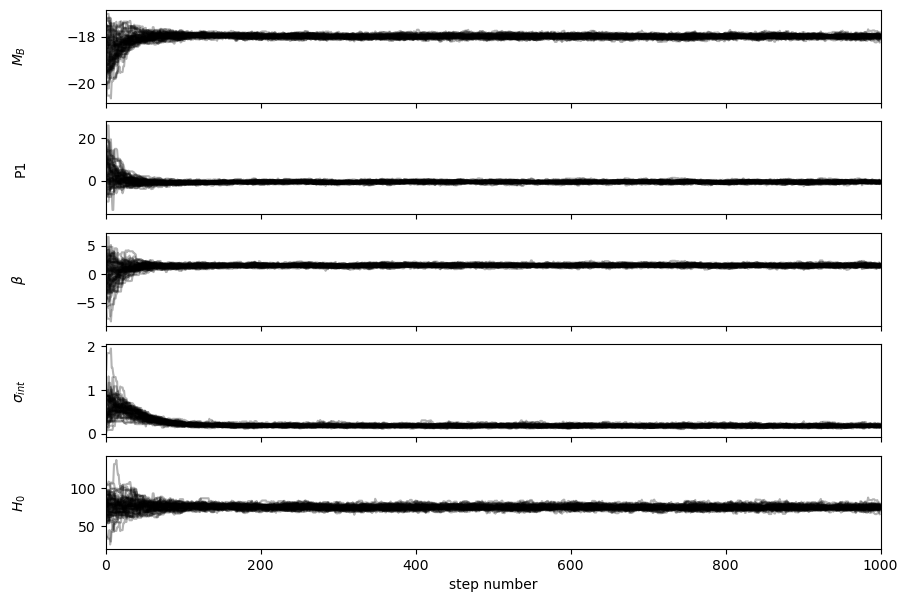

In [14]:
# Chains
clear_output(wait=True)

fig, axes = pl.subplots(5, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["$M_B$","P1", r"$\beta$", r"$\sigma_{int}$", r"$H_0$"]
for j in range(ndim):
    ax = axes[j]
    ax.plot(samples[:, :, j], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[j])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

#fig.savefig("../results/trippmethod/"+file[:-4]+"_chains.pdf")
pl.show()

In [15]:
samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))
#tau = sampler.get_autocorr_time()
#print(tau)

 # Printing results
for i, name in enumerate(labels):
    mcmc = np.percentile(samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    print(f"{name}: {mcmc[1]:.3f} (+{q[1]:.3f}/-{q[0]:.3f})")
    
    

$M_B$: -17.993 (+0.071/-0.066)
P1: -0.643 (+0.477/-0.483)
$\beta$: 1.521 (+0.203/-0.196)
$\sigma_{int}$: 0.174 (+0.025/-0.023)
$H_0$: 75.028 (+2.590/-2.511)


In [16]:
# Writing Result
p0_mcmc,p1_mcmc,beta_mcmc,sig_mcmc, H0_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))



f1 =open('../results/trippmethod/'+file[:-4]+'_result_trippLinear.txt','w') ### MUST change !!

f1.write('%s\t%s\t%s\t%s\t%s\n'%('p0','p1','beta','sig_int','H0'))



f1.write('%.3f\t%.3f\t%.3f\t%.3f\t%.3f\n'%(p0_mcmc[0],p1_mcmc[0],beta_mcmc[0],sig_mcmc[0],H0_mcmc[0]))

f1.write('%.3f\t%.3f\t%.3f\t%.3f\t%.3f\n'%(p0_mcmc[1],p1_mcmc[1],beta_mcmc[1],sig_mcmc[1],H0_mcmc[1]))
f1.write('%.3f\t%.3f\t%.3f\t%.3f\t%.3f\n'%(p0_mcmc[2],p1_mcmc[2],beta_mcmc[2],sig_mcmc[2],H0_mcmc[2]))

f1.close()

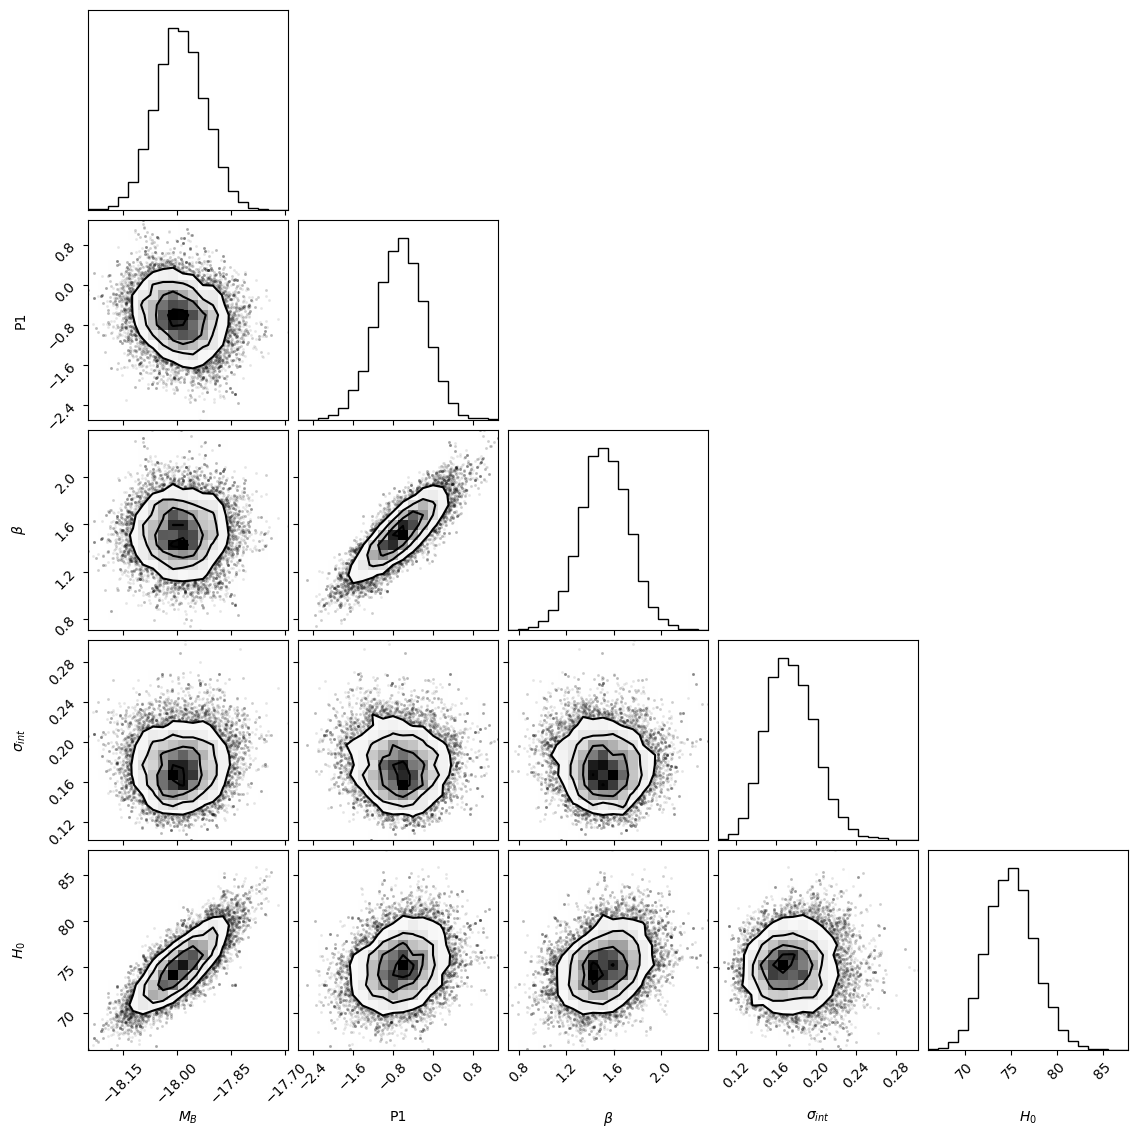

In [17]:
# Triangle plot
clear_output(wait=True)

figure = corner.corner(samples, labels = ["$M_B$","P1",r"$\beta$", r"$\sigma_{int}$", r"$H_0$"])
#figure.savefig("../results/trippmethod/"+file[:-4]+"_trippLinear"+str(nwalkers)+"_"+str(ssize)+".pdf")
pl.show()

In [18]:
import os

os.system('say "your program has finished."')


0